In [61]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import trapezoid

In [62]:
# Config
data_path = "/N/slate/jmelms/projects/ML_atmos_model_conservation_tests/A.mass_conservation/run_ACE2/output/initial_condition.nc"

In [63]:
# Load and summarize data
ds = xr.open_dataset(data_path)
ds

<xarray.Dataset> Size: 10MB
Dimensions:                 (sample: 1, lat: 180, lon: 360, ak: 9, bk: 9)
Coordinates:
  * lat                     (lat) float32 720B -89.24 -88.25 ... 88.25 89.24
  * lon                     (lon) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * ak                      (ak) float32 36B 0.0 5.12e+03 ... 3.057e+03 0.0
  * bk                      (bk) float32 36B 0.0 0.0 0.005378 ... 0.8739 1.0
Dimensions without coordinates: sample
Data variables: (12/39)
    air_temperature_1       (sample, lat, lon) float32 259kB ...
    eastward_wind_0         (sample, lat, lon) float32 259kB ...
    specific_total_water_1  (sample, lat, lon) float32 259kB ...
    northward_wind_7        (sample, lat, lon) float32 259kB ...
    northward_wind_6        (sample, lat, lon) float32 259kB ...
    northward_wind_1        (sample, lat, lon) float32 259kB ...
    ...                      ...
    eastward_wind_2         (sample, lat, lon) float32 259kB ...
    eastward_wind_6         (sample, lat, lon) float32 259kB ...
    eastward_wind_4         (sample, lat, lon) float32 259kB ...
    air_temperature_2       (sample, lat, lon) float32 259kB ...
    eastward_wind_7         (sample, lat, lon) float32 259kB ...
    time                    (sample) datetime64[ns] 8B ...
Attributes:
    source.git_sha:   83c058a
    source.job_id:    None
    history.created:  2025-11-07T19:15:24.010285
    title:            None

In [64]:
# See all variables
ds.data_vars.keys()

KeysView(Data variables:
    air_temperature_1       (sample, lat, lon) float32 259kB ...
    eastward_wind_0         (sample, lat, lon) float32 259kB ...
    specific_total_water_1  (sample, lat, lon) float32 259kB ...
    northward_wind_7        (sample, lat, lon) float32 259kB ...
    northward_wind_6        (sample, lat, lon) float32 259kB ...
    northward_wind_1        (sample, lat, lon) float32 259kB ...
    air_temperature_3       (sample, lat, lon) float32 259kB ...
    specific_total_water_5  (sample, lat, lon) float32 259kB ...
    air_temperature_4       (sample, lat, lon) float32 259kB ...
    specific_total_water_0  (sample, lat, lon) float32 259kB ...
    specific_total_water_6  (sample, lat, lon) float32 259kB ...
    northward_wind_4        (sample, lat, lon) float32 259kB ...
    PRESsfc                 (sample, lat, lon) float32 259kB ...
    northward_wind_2        (sample, lat, lon) float32 259kB ...
    Q2m                     (sample, lat, lon) float32 259kB ...


<xarray.Dataset> Size: 521kB
Dimensions:   (lat: 180, lon: 360)
Coordinates:
  * lat       (lat) float32 720B -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    ps_total  (lat, lon) float32 259kB 6.975e+04 6.973e+04 ... 9.992e+04
    ps_dry    (lat, lon) float32 259kB 6.964e+04 6.962e+04 ... 9.969e+04

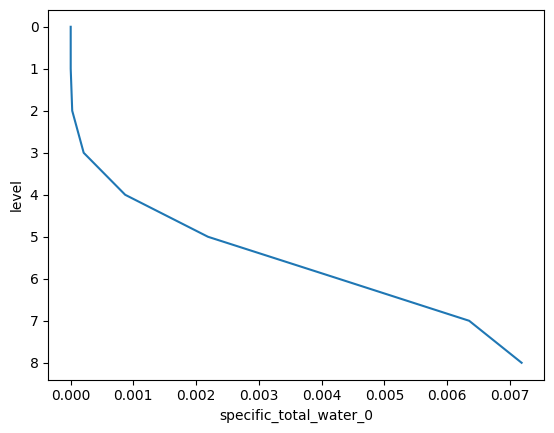

In [72]:
# Calculate pressure on levels 
names = dict(
    air_temperature="t",
    specific_total_water="q",
    eastward_wind="u",
    northward_wind="v",
    PRESsfc="sp",
    Q2m="q2m",
    TMP2m="t2m",
    UGRD10m="u10m",
    VGRD10m="v10m",
)
if "Q2m" in ds.variables:
    ds = ds.rename_vars({"Q2m": "specific_total_water_8"})
levs = [0, 1, 2, 3, 4, 5, 6, 7, 8]
ak = xr.DataArray(ds["ak"].values, dims=["level"], coords={"level": levs})
bk = xr.DataArray(ds["bk"].values, dims=["level"], coords={"level": levs})
q_vars = [ds[f"specific_total_water_{i}"].squeeze().assign_attrs(level=i) for i in levs]
qds = xr.concat(q_vars, dim="level")
qds.mean(dim=["lat", "lon"]).plot(y="level", yincrease=False)
ps = ds["PRESsfc"].squeeze()
p_levels = ak + bk * ps
g = 9.80665  # m/s^2
tcw = trapezoid(y=qds, x=p_levels, axis=0)
ps_moist = tcw * g
ps_dry = ps - ps_moist
ps = ps.to_dataset(name="ps_total")
# ps["ps_moist"] = ps_moist
ps["ps_dry"] = ps_dry
ps